<h1 style='color:#4c4893' align='center'>
   Potato Disease Classification
  </h1>

### Import all the Dependencies

In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
from tensorflow.keras.utils import plot_model

2024-02-04 23:51:28.441072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 23:51:28.441182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 23:51:28.576645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 5.2 MB/s eta 0:00:0000:01


### Set all the Constants

In [2]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "/kaggle/input/potato-plant-disease-data/PlantVillage"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE


## Initializing, Exploring & Partioning the Dataset

### Function to Split Dataset

<div style="background-color:white; color:black; font-size:15px; font-family:Comic Sans MS; padding:10px; border: 5px solid black;font-weight:bold;border-radius: 20px;">
    Dataset should be bifurcated into 3 subsets, namely:

* Training: Dataset to be used while training
* Validation: Dataset to be tested against while training
* Test: Dataset to be tested against after we trained a model
</div>

In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


### Reading and Partitioning the Dataset

<div style="background-color:white; color:black; font-size:15px; font-family:Comic Sans MS; padding:10px; border: 5px solid black;font-weight:bold;border-radius: 20px;">
We create a Tensorflow Dataset Object and directly read it from the directory using <span style="color:orangered"> `image_dataset_from_directory`</span> and then split it using the function we created above
</div>

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


### Checking the Available Classes

In [5]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


### Displaying Some Sample Images

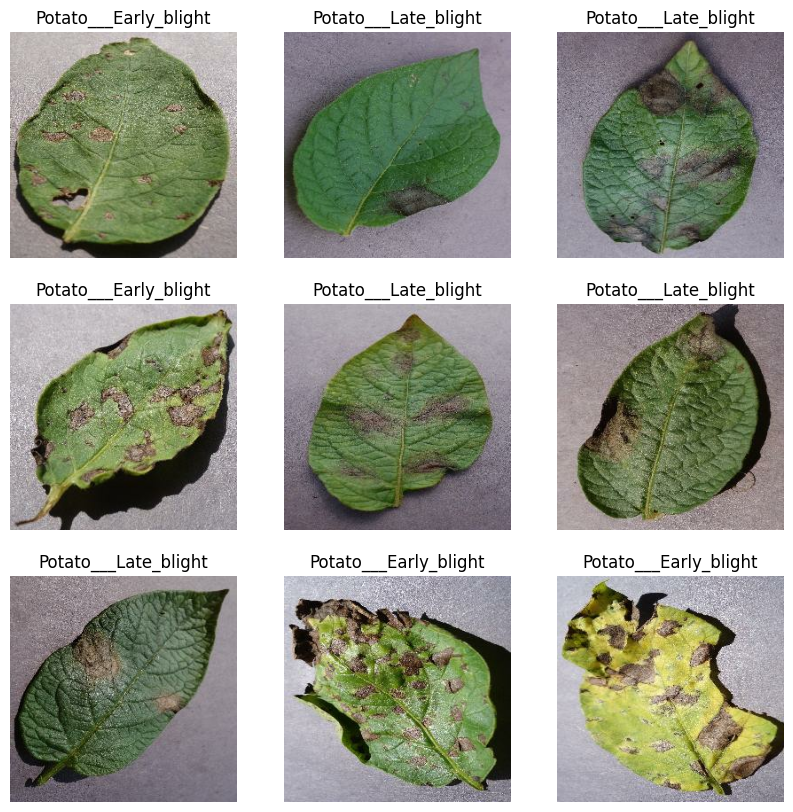

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Checking Batch Size

In [7]:
for image_batch, labels_batch in train_ds:    
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization

<div style="background-color:white; color:black; font-size:15px; font-family:Comic Sans MS; padding:10px; border: 5px solid black;font-weight:bold;border-radius: 20px;">
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.
</div>

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

<div style="background-color:white; color:black; font-size:15px; font-family:Comic Sans MS; padding:10px; border: 5px solid black;font-weight:bold;border-radius: 20px;">
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
</div>

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


#### Checking what is the expected dimension order for channel

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture

<div style="background-color:white; color:black; font-size:15px; font-family:Comic Sans MS; padding:10px; border: 5px solid black;font-weight:bold;border-radius: 20px;">
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.
</div>

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

### Model Summary

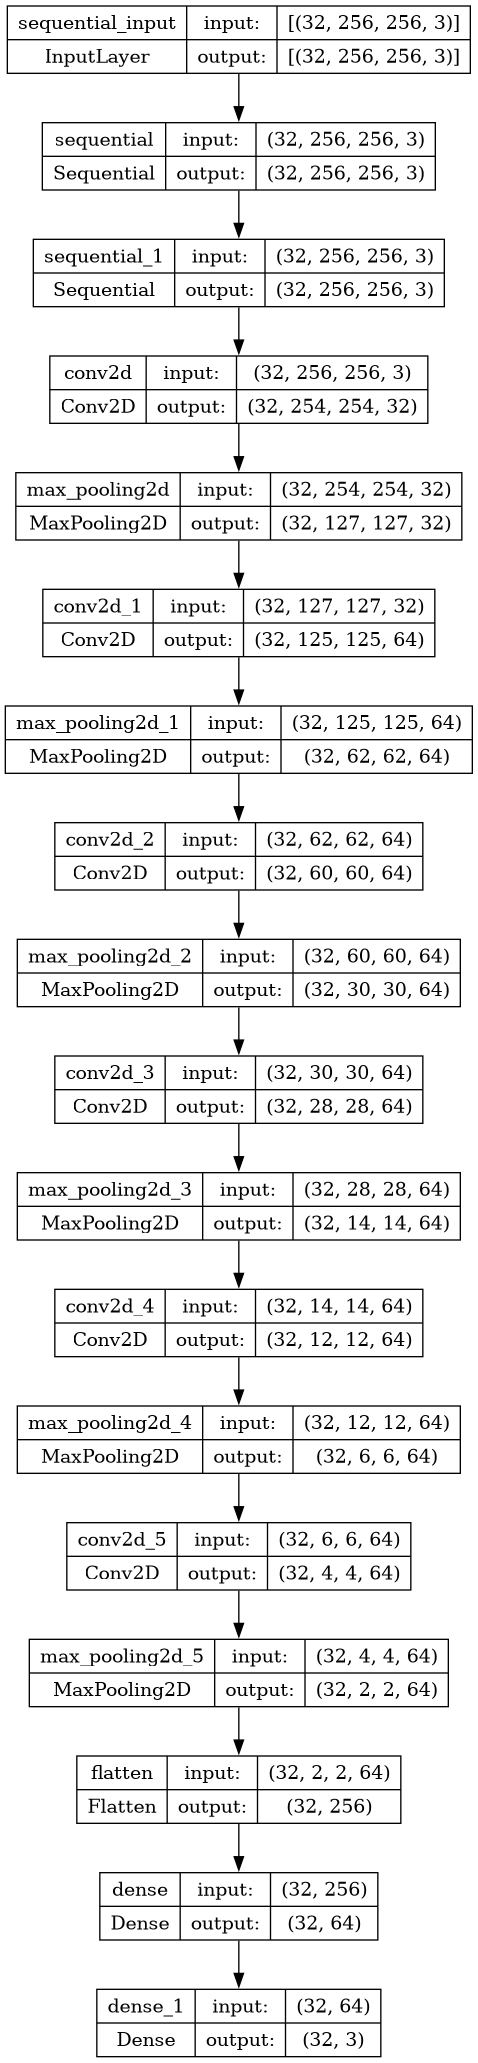

In [13]:
plot_model(model, show_shapes=True)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

### Compiling the Model

<div style="background-color:white; color:black; font-size:15px; font-family:Comic Sans MS; padding:10px; border: 5px solid black;font-weight:bold;border-radius: 20px;">
We use  <span style="color:orangered"> `adam`</span> Optimizer, <span style="color:olive"> `SparseCategoricalCrossentropy`</span> for losses, <span style="color:blue"> `accuracy`</span> as a metric
    
</div>

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the Network

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30


I0000 00:00:1707090729.466852     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 [==============================] - 13s 88ms/step - loss: 0.7387 - accuracy: 0.6696 - val_loss: 0.4588 - val_accuracy: 0.8021
Epoch 2/30
54/54 [==============================] - 2s 40ms/step - loss: 0.3567 - accuracy: 0.8533 - val_loss: 0.4731 - val_accuracy: 0.8073
Epoch 3/30
54/54 [==============================] - 2s 40ms/step - loss: 0.2477 - accuracy: 0.8955 - val_loss: 0.2520 - val_accuracy: 0.9010
Epoch 4/30
54/54 [==============================] - 2s 39ms/step - loss: 0.2299 - accuracy: 0.9043 - val_loss: 0.2663 - val_accuracy: 0.8854
Epoch 5/30
54/54 [==============================] - 2s 39ms/step - loss: 0.2188 - accuracy: 0.9126 - val_loss: 0.1491 - val_accuracy: 0.9427
Epoch 6/30
54/54 [==============================] - 2s 40ms/step - loss: 0.1612 - accuracy: 0.9337 - val_loss: 0.1876 - val_accuracy: 0.9167
Epoch 7/30
54/54 [==============================] - 2s 40ms/step - loss: 0.1199 - accuracy: 0.9525 - val_loss: 0.1156 - val_accuracy: 0.9531
Epoch 8/30
54/54 [=====

### Testing the Model

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 17ms/step - loss: 0.1259 - accuracy: 0.9648
Test Accuracy: 96.48%


## Create a Quantization Aware Model
https://www.tensorflow.org/model_optimization/guide/quantization/training_example

### Quantize only the Dense, MaxPool2D, Conv2D Layers

In [18]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer



### Clone the Model and Make Quantization Aware 

In [19]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 quant_conv2d (QuantizeWrap  (None, 254, 254, 32)      963       
 perV2)                                                          
                                                                 
 quant_max_pooling2d (Quant  (None, 127, 127, 32)      1         
 izeWrapperV2)                                                   
                                                                 
 quant_conv2d_1 (QuantizeWr  (None, 125, 125, 64)      18627     
 apperV2)                                                        
                                                      

### Compile Quantization Aware Model before Fine Tuning

In [20]:
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Fine Tuning the Quantization Aware Model

In [21]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)


Epoch 1/20
54/54 [==============================] - 8s 66ms/step - loss: 0.1028 - accuracy: 0.9624 - val_loss: 0.0813 - val_accuracy: 0.9792
Epoch 2/20
54/54 [==============================] - 3s 60ms/step - loss: 0.0634 - accuracy: 0.9795 - val_loss: 0.1651 - val_accuracy: 0.9479
Epoch 3/20
54/54 [==============================] - 3s 60ms/step - loss: 0.0832 - accuracy: 0.9718 - val_loss: 0.0406 - val_accuracy: 0.9896
Epoch 4/20
54/54 [==============================] - 3s 60ms/step - loss: 0.0722 - accuracy: 0.9707 - val_loss: 0.0699 - val_accuracy: 0.9844
Epoch 5/20
54/54 [==============================] - 3s 60ms/step - loss: 0.0813 - accuracy: 0.9695 - val_loss: 0.0914 - val_accuracy: 0.9792
Epoch 6/20
54/54 [==============================] - 3s 60ms/step - loss: 0.0864 - accuracy: 0.9636 - val_loss: 0.1349 - val_accuracy: 0.9479
Epoch 7/20
54/54 [==============================] - 3s 60ms/step - loss: 0.0656 - accuracy: 0.9789 - val_loss: 0.0835 - val_accuracy: 0.9792
Epoch 8/20
54

### Evaluate the Model Accuracy

In [22]:
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating Quant Aware model accuracy
8/8 [==============================] - 0s 18ms/step - loss: 0.0492 - accuracy: 0.9883
Test Accuracy: 98.83%


## Convert Quanitzation Aware Model to TF Lite Model

### Convert the Model

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()


/opt/conda/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 4, Total Ops 43, % non-converted = 9.30 %
 * 4 ARITH ops

- arith.constant:    4 occurrences  (f32: 2, i32: 2)



  (uq_8: 5, f32: 1)
  (f32: 1)
  (uq_8: 2)
  (uq_8: 6)
  (uq_8: 7, uq_32: 7)
  (uq_8: 1)
  (uq_8: 1)
  (f32: 1)
  (uq_8: 1)
  (uq_8: 3)


### Evaluate the TF Lite Model

In [24]:
def evaluate_tflite_model(dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Quant TFLite test_accuracy: 0.8736059479553904


### Saving the TF Lite Model

In [25]:
import os

with open("/kaggle/working/model.tflite", 'wb') as f:
    f.write(quantized_tflite_model)

### Plotting the Inference Data

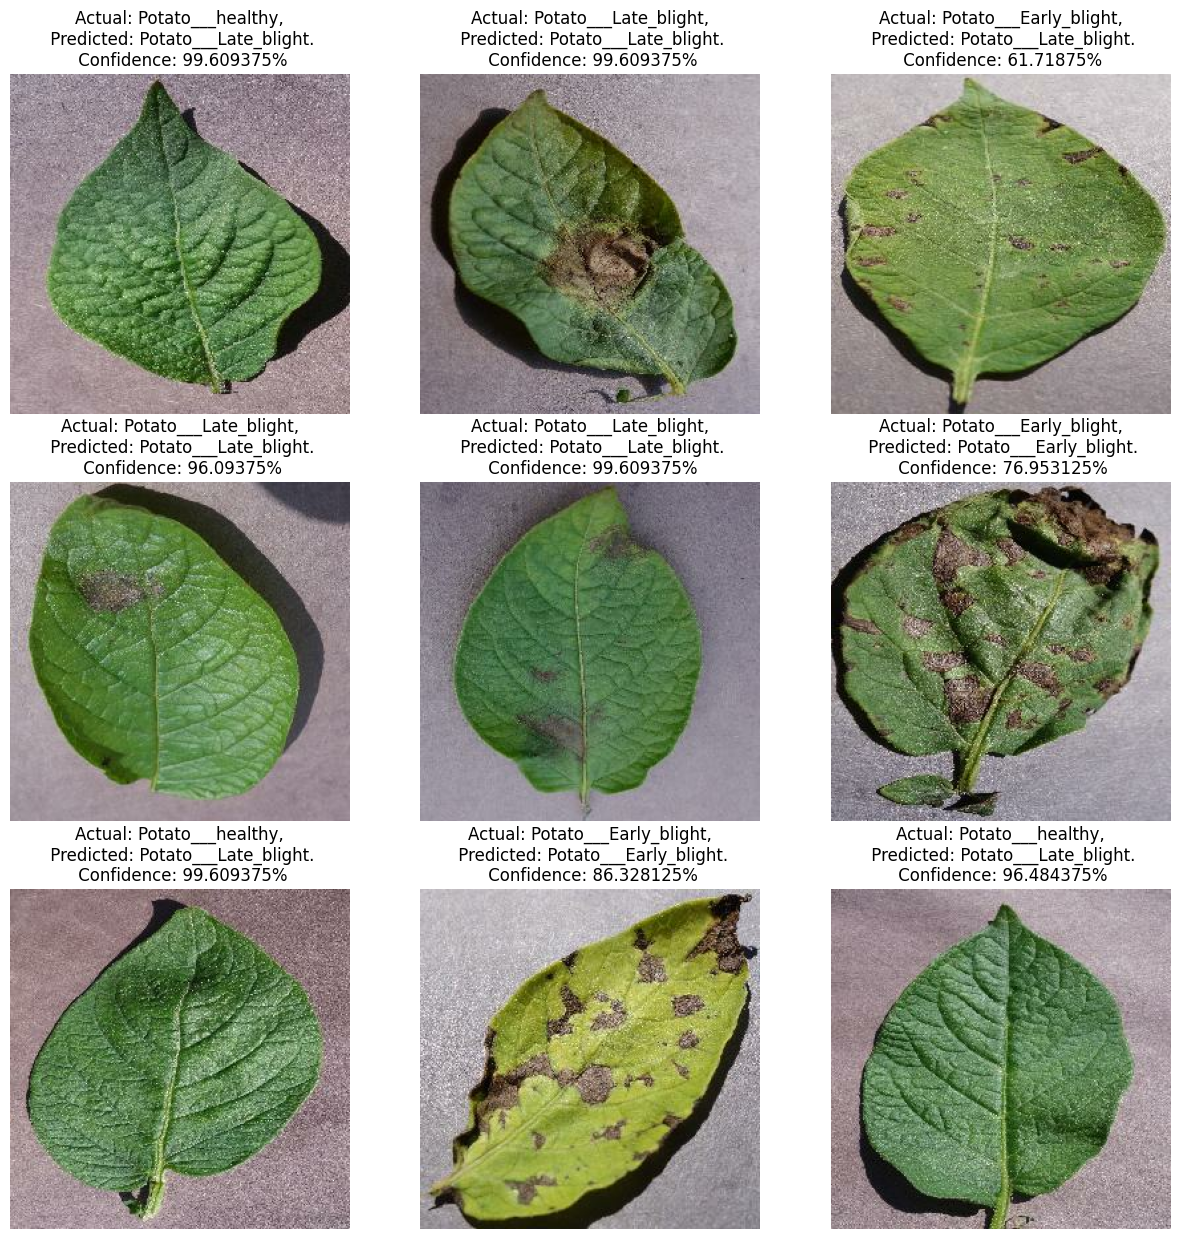

In [26]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

<div style="background-color:#4c4893; color:white; font-size:15px; font-family:Comic Sans MS; padding:10px; border: 5px solid black;font-weight:bold;border-radius: 20px;text-align:center"> ✨ THE END ✨</div><br>